In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

In [2]:
## Read the Excel sheet names
pathToFile = r"./data/DataAll.xlsx"
keysToSearch = load_workbook(pathToFile,read_only=True).sheetnames

In [3]:
## Import and save as a dict(pd.DataFrame)
usecols = ["Sample Name",
           "Sample ID",
           "Analyte Peak Area (counts)",
           "Analyte Peak Height (cps)",
           "Calculated Concentration (ng/mL)"]

allData = {k:None for k in keysToSearch}
for key in keysToSearch:
    allData[key] = pd.read_excel(pathToFile,sheet_name=key,usecols=usecols,na_values=['< 0', 'No Intercept'])

## Read the time metadata for each sample
pathToFile = r"./data/Time.xlsx"
time = pd.read_excel(pathToFile,sheet_name="Time",index_col="Sample ID")

In [4]:
#Filter data not corresponding to effluent
allEffluent = {k:None for k in keysToSearch}
for key,data in allData.items():
    allEffluent[key] = data
    allEffluent[key] = allEffluent[key][allEffluent[key]["Sample Name"].str.contains("standard") == False]
    allEffluent[key] = allEffluent[key][allEffluent[key]["Sample Name"].str.contains("Influent") == False]

In [5]:
#Extract only concentrations and group samples
strConc = 'Calculated Concentration (ng/mL)'
strID = 'Sample Name'
allGroupedSamples = {k:None for k in keysToSearch}
for key,data in allEffluent.items():
    allGroupedSamples[key] = data[[strID,strConc]].groupby(by=[strID],as_index=True,sort=False)

In [6]:
## Calculate mean and stdev of each group of three samples
allStatistics = {k:None for k in keysToSearch}
for key,data in allGroupedSamples.items():
    allStatistics[key] = pd.concat([time[["Cumulative Time (min)"]],
                                    data.mean().rename(columns={strConc:"mean"}),
                                    data.std().rename(columns={strConc:"std"}),
                                    data.count().rename(columns={strConc:"nSamples"})], axis = 1)

/home/edsaa/venv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/edsaa/venv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


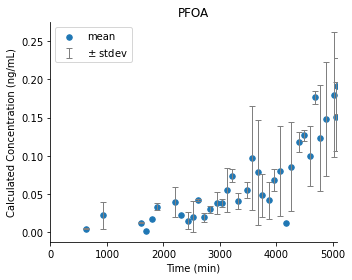

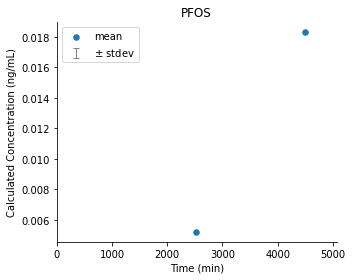

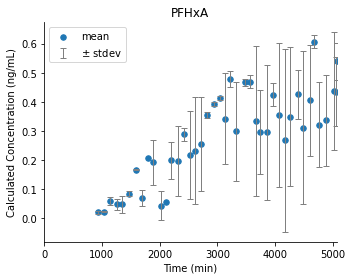

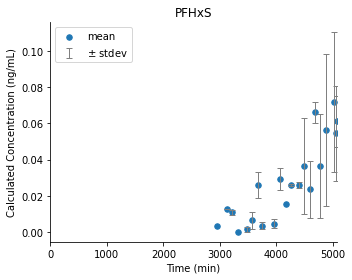

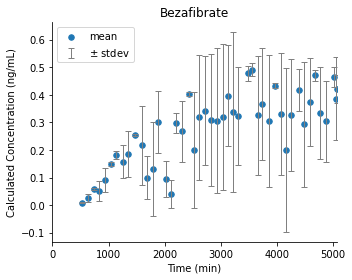

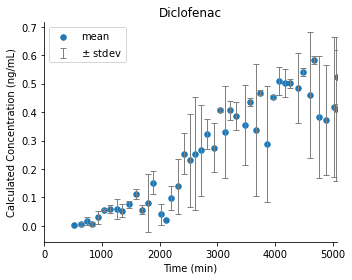

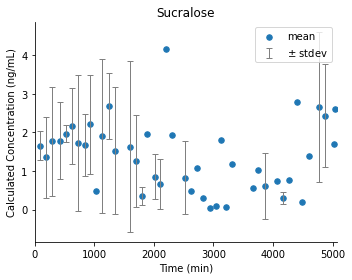

In [7]:
for key,statistics in allStatistics.items():
    fig,ax = plt.subplots(figsize=(5,4),tight_layout=True)
    ax.scatter(statistics["Cumulative Time (min)"],statistics["mean"],s=30,label="mean")
    ax.errorbar(statistics["Cumulative Time (min)"],statistics["mean"],statistics["std"],
                lw=0,c='k',marker=None,ecolor='gray',elinewidth=1,capsize=3,label=r'$\pm$ stdev')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel(strConc)
    ax.set_title(key)
    ax.legend()
    ax.set_xlim(0,statistics["Cumulative Time (min)"].max())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()